In [1]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import sklearn
from sklearn.impute import SimpleImputer
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.decomposition import PCA

#### INDEX

- Initial EDA
- Feature Engineering (Feature Creation)
- Insight Extraction from the features
- KMeans clustering
  - Elbow method & Loop implementation
  - PCA execution for visualization purposes
  - Conclusion

In [2]:
# Read the dataset
df = pd.read_csv('inpatientCharges.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   DRG Definition                        163065 non-null  object
 1   Provider Id                           163065 non-null  int64 
 2   Provider Name                         163065 non-null  object
 3   Provider Street Address               163065 non-null  object
 4   Provider City                         163065 non-null  object
 5   Provider State                        163065 non-null  object
 6   Provider Zip Code                     163065 non-null  int64 
 7   Hospital Referral Region Description  163065 non-null  object
 8    Total Discharges                     163065 non-null  int64 
 9    Average Covered Charges              163065 non-null  object
 10   Average Total Payments               163065 non-null  object
 11  Average Medic

In [3]:
# Convert Average Payment to float and drop relatively lower important columns for the sake of simplicity
df['Avg_Payment']  = df[' Average Total Payments '].astype(str).str.split(r"\$", expand=True)[1].astype(float)
df['Avg_Medicare_Payment']  = df['Average Medicare Payments'].astype(str).str.split(r"\$", expand=True)[1].astype(float)
drops = ['Provider Street Address',' Average Covered Charges ',' Average Total Payments ','Provider Name','Hospital Referral Region Description','Average Medicare Payments']
df = df.drop(drops,axis=1)

In [4]:
# Imported zipcode median household income and merged with the file
# source : https://www.psc.isr.umich.edu/dis/census/Features/tract2zip/
df_zip = pd.read_csv('medianzip2.csv')
df = df.merge(df_zip,how='left',left_on='Provider Zip Code', right_on='Zip').rename(columns = {'Median_Income':'Med_Income_by_Zip'}).drop('Zip',axis=1)

In [5]:
# How many unique cities are there in the dataset?
df['Provider City'].nunique()

1977

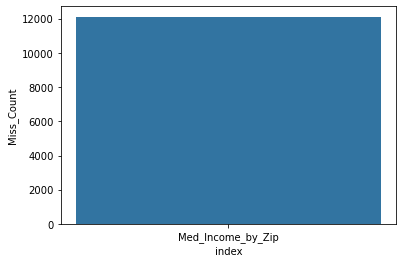

In [6]:
# Missing Value Detection
df_mis = pd.DataFrame(df.isnull().sum()).reset_index().sort_values(by=0,ascending=False).rename(columns={0:'Miss_Count'})
sns.barplot(x= 'index', y = 'Miss_Count', data = df_mis[df_mis['Miss_Count']>0])

In [7]:
# Missing Value Imputation with Median
median_impute = df.Med_Income_by_Zip.median()
df = df.fillna(median_impute)

In [8]:
df.head()

,DRG Definition,Provider Id,Provider City,Provider State,Provider Zip Code,Total Discharges,Avg_Payment,Avg_Medicare_Payment,Med_Income_by_Zip
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,DOTHAN,AL,36301,91,5777.24,4763.73,38008.0
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,BOAZ,AL,35957,14,5787.57,4976.71,33993.0
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,FLORENCE,AL,35631,24,5434.95,4453.79,46652.0
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,BIRMINGHAM,AL,35235,25,5417.56,4129.16,54491.0
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,ALABASTER,AL,35007,18,5658.33,4851.44,66251.0


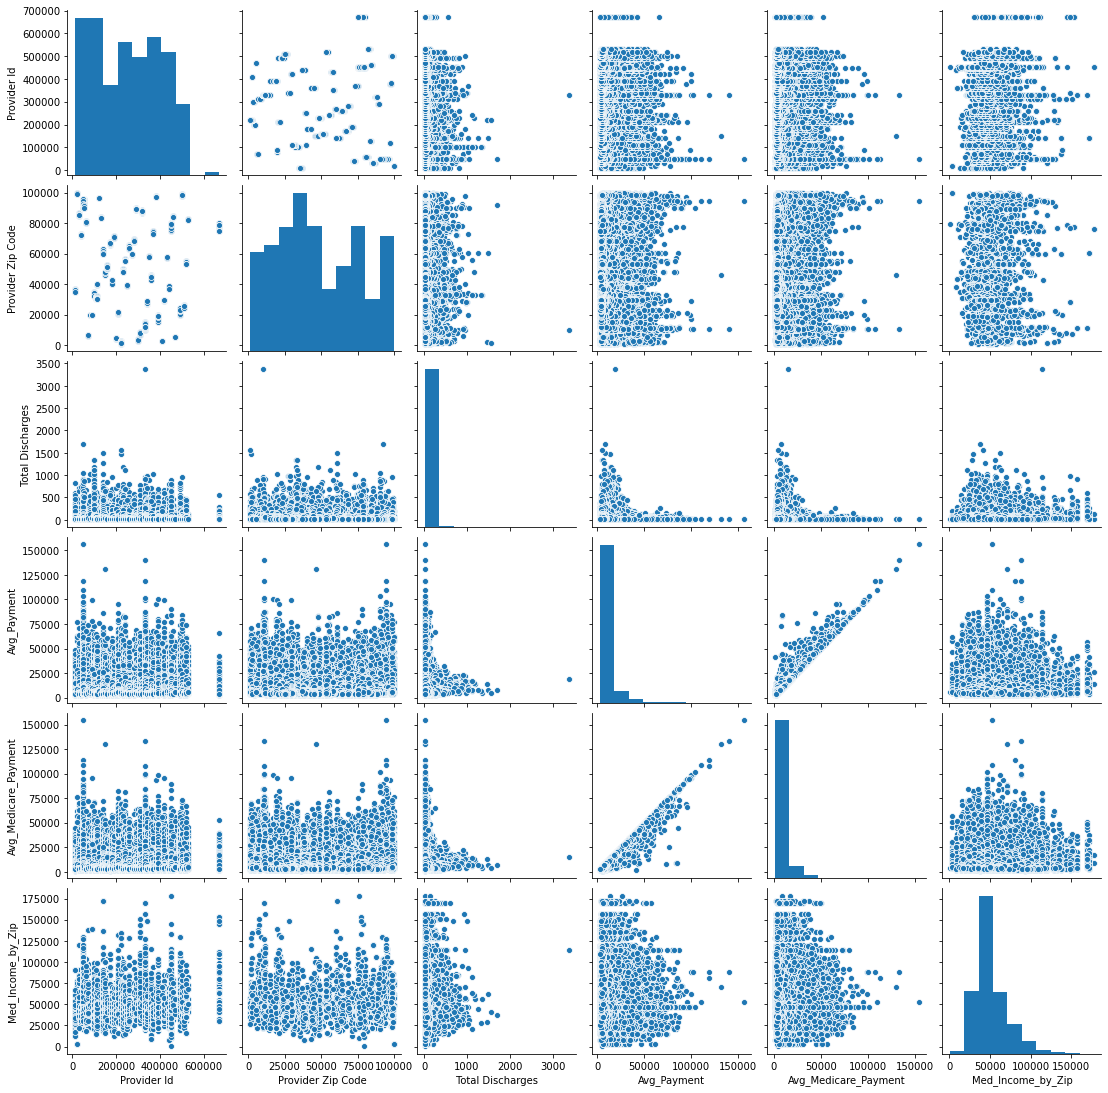

In [9]:
# Having a first glance at the data shows that the distribution of 'avg_payment' is right skewed indicating outlier values
# Plus, there seems to be some hospitals with relatively lower discharge despite high avg.payment
sns.pairplot(df) 

## Feature Engineering (New Feature Creation)

In [10]:
# Feature 1-2
# Grouping DRG Definition and State information to get median and standard deviation values
# If there is a state-wise abnormality in any DRG section these features will capture this by measuring median and standard deviation
cols_to_use = ['DRG Definition','Provider State','Avg_Payment']
cols_to_group = ['DRG Definition','Provider State']

ft1 = pd.DataFrame(df[cols_to_use].groupby(cols_to_group, as_index=False).median()).rename(columns = {'Avg_Payment':'Avg_Payment_DRG_State'})
df = ft1.merge(df,how='left',left_on=cols_to_group, right_on=cols_to_group)

ft2 = pd.DataFrame(df[cols_to_use].groupby(cols_to_group).std()).rename(columns = {'Avg_Payment':'Avg_Payment_DRG_State_Std'}).reset_index()
df = ft2.merge(df,how='left',left_on=cols_to_group, right_on=cols_to_group)

In [11]:
# Feature 3-4-5
# Grouping DRG Definition and Zip Code to get median, minimum and maximum values
# Compared to state-wise information, zip code returns a more micro perspective and with minimum,maximum and median value aggregations,this could help flagging outlying information 
cols_to_use = ['DRG Definition','Provider Zip Code','Avg_Payment']
cols_to_group = ['DRG Definition','Provider Zip Code']

ft3 = pd.DataFrame(df[cols_to_use].groupby(cols_to_group, as_index=False).median()).rename(columns = {'Avg_Payment':'Avg_Payment_DRG_Zip'})
df = ft3.merge(df,how='left',left_on=cols_to_group, right_on=cols_to_group)

ft4 = pd.DataFrame(df[cols_to_use].groupby(cols_to_group, as_index=False).min()).rename(columns = {'Avg_Payment':'Avg_Payment_DRG_Zip_Min'})
df = ft4.merge(df,how='left',left_on=cols_to_group, right_on=cols_to_group)

ft5 = pd.DataFrame(df[cols_to_use].groupby(cols_to_group, as_index=False).max()).rename(columns = {'Avg_Payment':'Avg_Payment_DRG_Zip_Max'})
df = ft5.merge(df,how='left',left_on=cols_to_group, right_on=cols_to_group)

In [12]:
# Now I am gonna break it down based on Hospitals.There are 3337 hospitals in the dataset
df['Provider Id'].nunique()

3337

In [13]:
# Feature 6-7-8
# Grouping Hospitals(Provider ID) and Zip Code to get median, standard deviation  and maximum values
# Now, instead of a DRG-wise fraud detection, I focused on hospital-wise possible abnormalities. 
cols_to_group = ['Provider Id','Provider Zip Code']
cols_to_use = ['Provider Id','Avg_Payment','Provider Zip Code']

ft6 = pd.DataFrame(df[cols_to_use].groupby(cols_to_group, as_index=False).median()).rename(columns = {'Avg_Payment':'Avg_Payment_Hospital_Zip'})
df = ft6.merge(df,how='left',left_on=cols_to_group, right_on=cols_to_group)

ft7 = pd.DataFrame(df[cols_to_use].groupby(cols_to_group).std()).rename(columns = {'Avg_Payment':'Avg_Payment_Hospital_Zip_Std'}).reset_index()
df = ft7.merge(df,how='left',left_on=cols_to_group, right_on=cols_to_group)

ft8 = pd.DataFrame(df[cols_to_use].groupby(cols_to_group, as_index=False).max()).rename(columns = {'Avg_Payment':'Avg_Payment_Hospital_Zip_Max'})
df = ft8.merge(df,how='left',left_on=cols_to_group, right_on=cols_to_group)

In [14]:
# Feature 9
# Average Household Income by Hospital and Zip Code 
# Income needs to be go in line with the avg.payment. Otherwise, a suspicious environment would emerge
cols_to_group = ['Provider Id']
cols_to_use = ['Provider Id','Med_Income_by_Zip']

ft9 = pd.DataFrame(df[cols_to_use].groupby(cols_to_group, as_index=False).mean()).rename(columns = {'Med_Income_by_Zip':'Avg_ Hospital_Zip_HH_Income'})
df = ft9.merge(df,how='left',left_on=cols_to_group, right_on=cols_to_group)

In [15]:
# Feature 10 
# By getting the average hospital discharges I target at spotting hospitals with extreme values of discharges
cols_to_group = ['Provider Id']
cols_to_use = ['Provider Id',' Total Discharges ']

ft10 = pd.DataFrame(df[cols_to_use].groupby(cols_to_group, as_index=False).mean()).rename(columns = {' Total Discharges ':'Avg_ Hospital_Discharges'})
df = ft10.merge(df,how='left',left_on=cols_to_group, right_on=cols_to_group)

Text(0.5, 1.0, 'Correlation Heatmap')

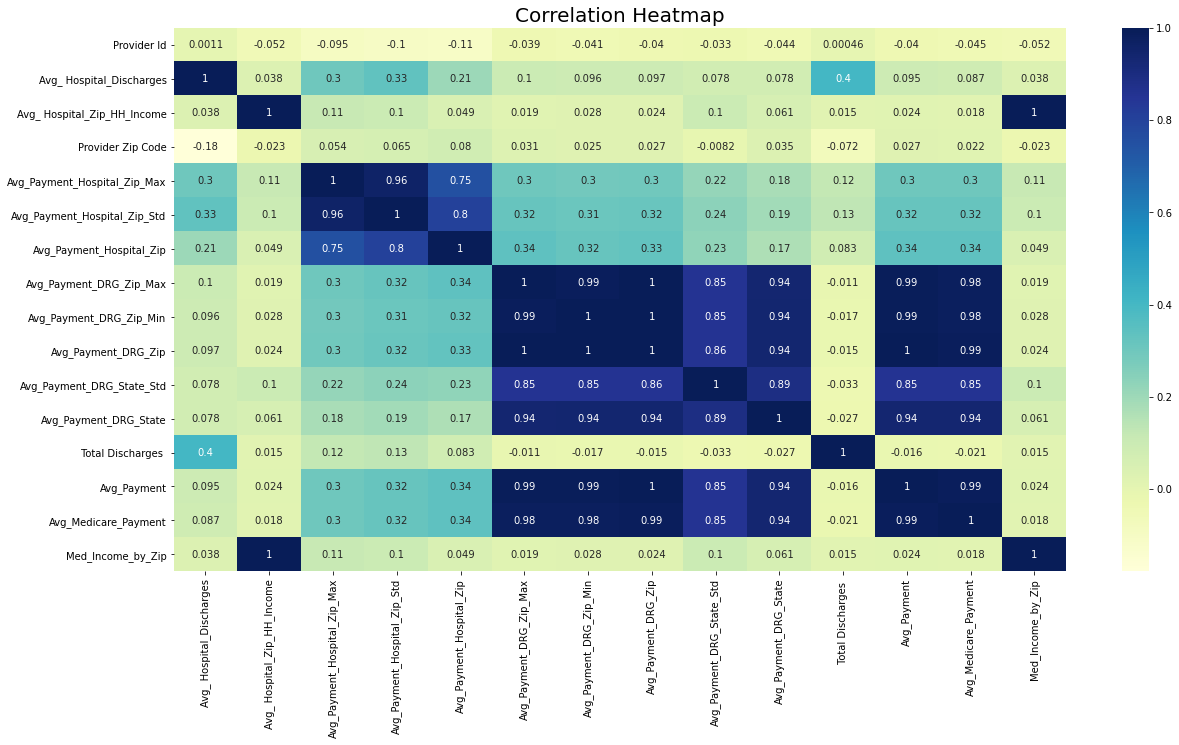

In [16]:
# Exploring the correlation heatmap following feature engineering operations
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# Compute the correlation matrix
drops = ['Provider Id', 'Provider Zip Code']
corr = df.select_dtypes(include=numerics).corr().drop(drops,axis=1)

plt.figure(figsize=(20,10))
sns.heatmap(corr,annot=True,cmap='YlGnBu', square=False)
plt.title('Correlation Heatmap',size=20)

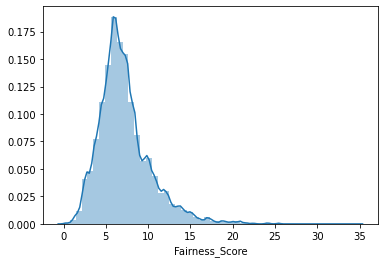

In [17]:
# Feature 11
# The ratio of Avg_Payment to Household Income by the Zip Code could be a significant indicator in terms 'fairness'
# I will call this new feature 'Fairness_Score' - the more the healthier and vice versa
df['Fairness_Score'] = df['Med_Income_by_Zip'] / df['Avg_Payment_Hospital_Zip']
sns.distplot(df['Fairness_Score'])

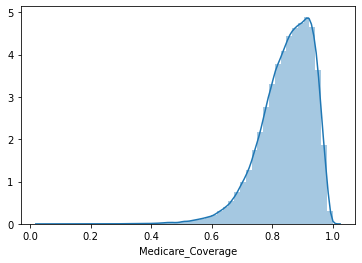

In [18]:
# Feature 12
# The ratio of Avg_Medicare_Payment to Avg_Payment could be a significant indicator in terms 'Insurance Coverage Rate'
# I will call this new feature 'Social_Score' 
df['Medicare_Coverage'] = df['Avg_Medicare_Payment'] / df['Avg_Payment']
sns.distplot(df['Medicare_Coverage'])

In [19]:
# Feature 13
# Total count of state-wise treatments by Grouping DRG Definitions. If a specific state extremely treated more patients in a specific DRG that might raise a flag
cols_to_group = ['Provider State','DRG Definition']
cols_to_use = ['Provider State','DRG Definition','Provider Id']

ft13 = pd.DataFrame(df[cols_to_use].groupby(cols_to_group, as_index=False).count()).rename(columns = {'Provider Id':'Treatment_Count_by_DRG'})
df = ft13.merge(df,how='left',left_on=cols_to_group, right_on=cols_to_group)

## INSIGHT EXTRACTION FROM CREATED FEATURES

Text(0.5, 1.0, 'Household Income vs Avg. Payment by Zip Code ')

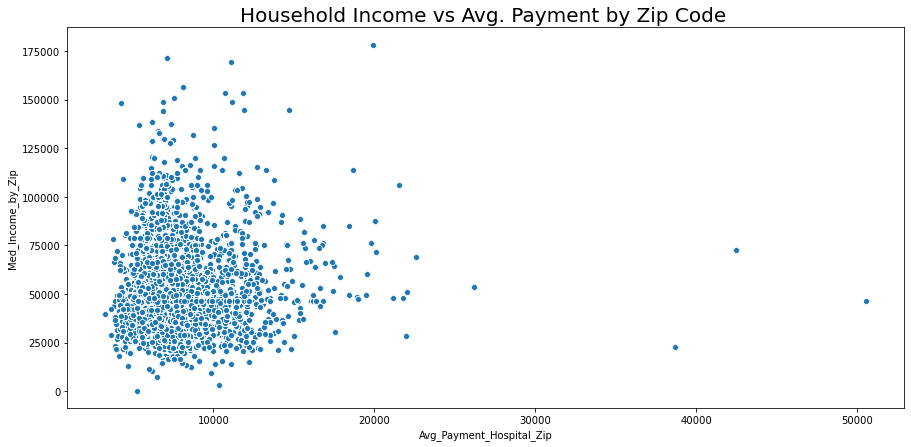

In [21]:
# Hospitals with disproportionate avg_payment vs median household income are usual suspects for fraud 
plt.figure(figsize=(15,7))
sns.scatterplot(x='Avg_Payment_Hospital_Zip',y='Med_Income_by_Zip',data=df)
plt.title('Household Income vs Avg. Payment by Zip Code ',size=20)

Text(0.5, 1.0, 'Avg Payment by DRG Definitions')

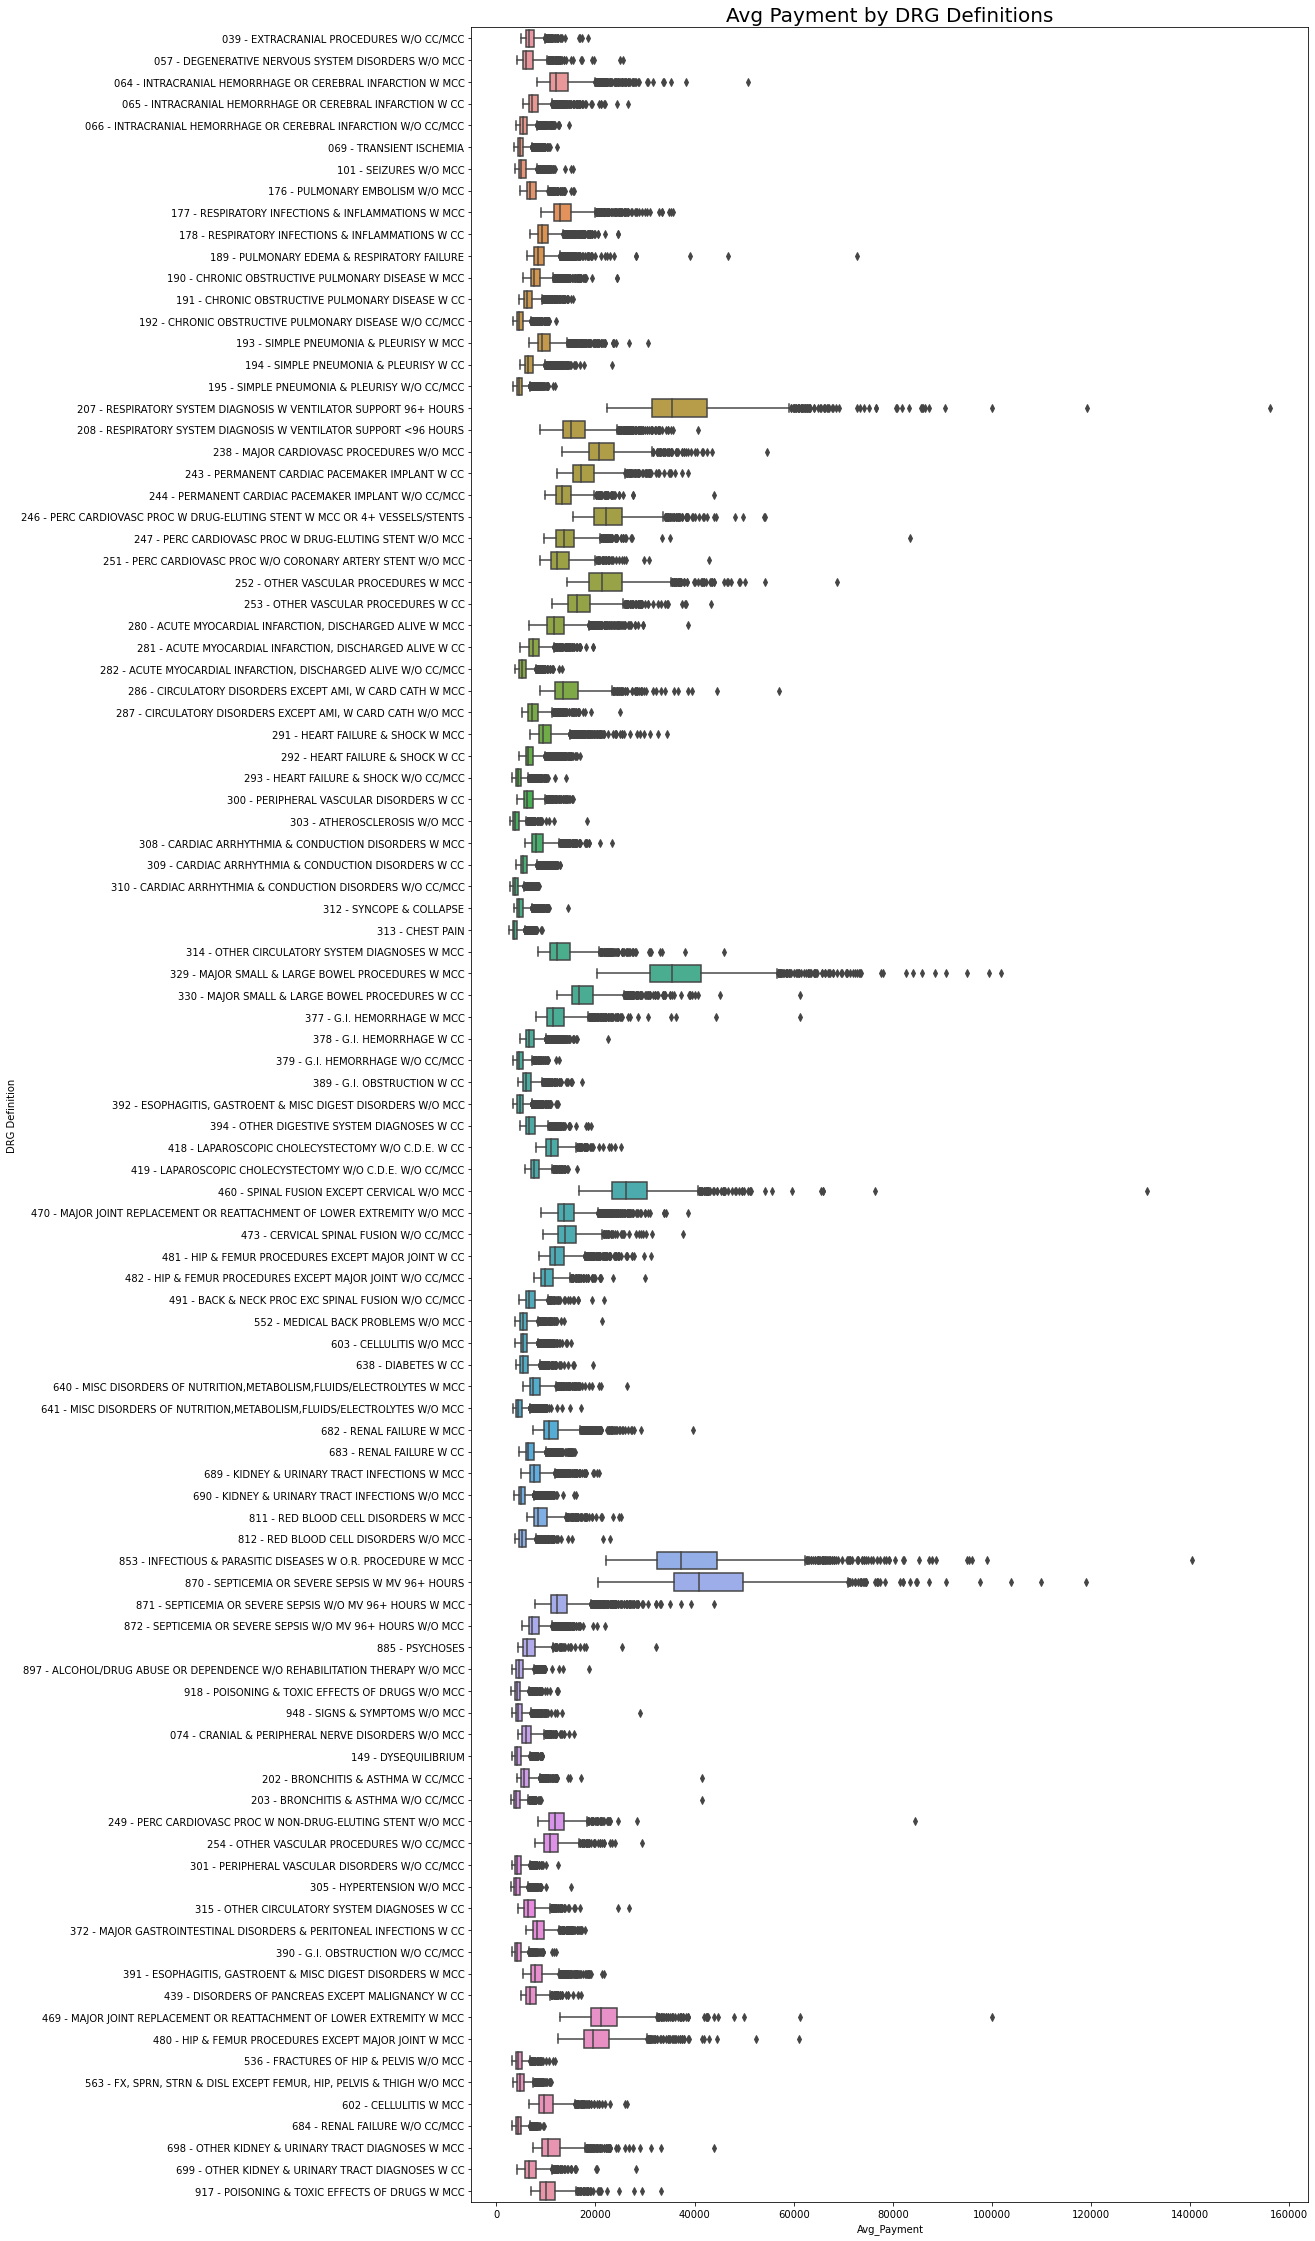

In [22]:
# Several DRG's have relatively higher variance and this needs to be further inspected 
plt.figure(figsize=(15,40))
sns.boxplot(x='Avg_Payment',y='DRG Definition',data=df)
plt.title('Avg Payment by DRG Definitions',size=20)

Text(0.5, 1.0, 'Top 10 City by Highest Varience in Avg.Payment')

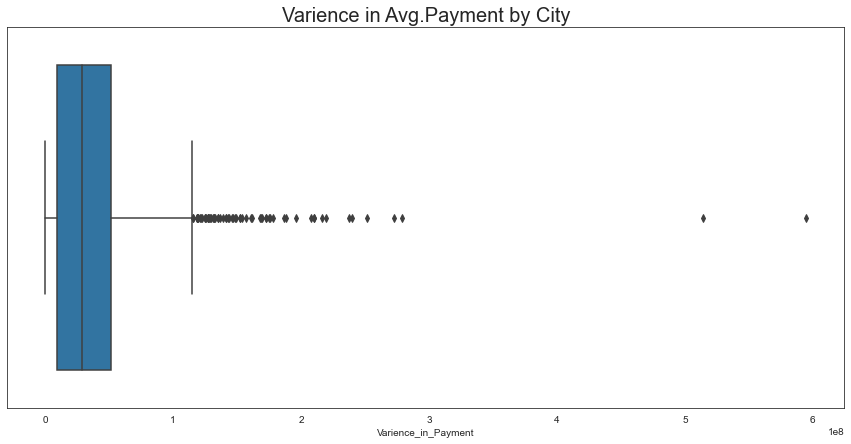

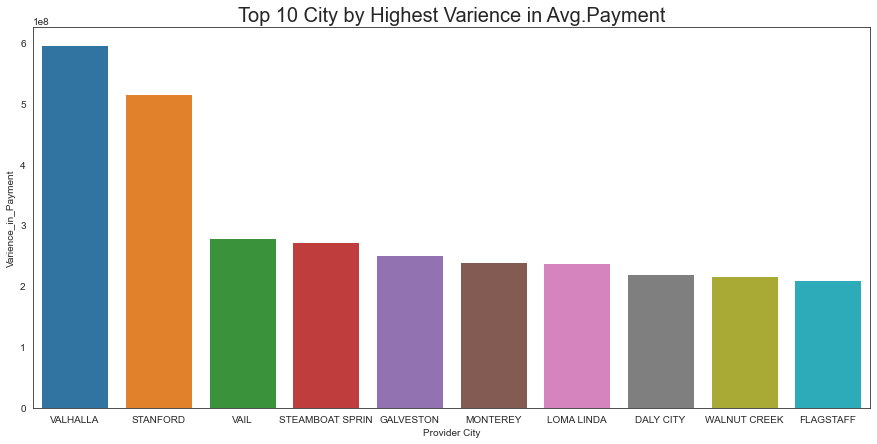

In [23]:
# Looking through the varience in Avg.Payment city-wise, especially Valhalla and Standford outlies with their extreme variance levels
cols_to_group = ['Provider City']
cols_to_use = ['Provider City','Avg_Payment']
varience = pd.DataFrame(df[cols_to_use].groupby(cols_to_group, as_index=False).var()).rename(columns = {'Avg_Payment':'Varience_in_Payment'}).dropna()
plt.figure(figsize=(15,7))
sns.set_style("white")
sns.boxplot(varience.Varience_in_Payment)
plt.title('Varience in Avg.Payment by City',size=20)
# Vısualizing top 10 cities in terms of varience in avg. payment
plt.figure(figsize=(15,7))
sns.set_style("white")
top10 = varience.sort_values(by='Varience_in_Payment',ascending=False).head(10)
sns.barplot(y='Varience_in_Payment',x='Provider City',data=top10)
plt.title('Top 10 City by Highest Varience in Avg.Payment',size=20)

## CLUSTERING

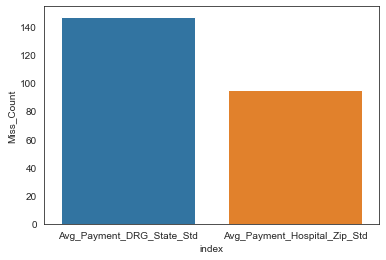

In [24]:
# Missing Value Detection after feature engineering
df_mis = pd.DataFrame(df.isnull().sum()).reset_index().sort_values(by=0,ascending=False).rename(columns={0:'Miss_Count'})
sns.barplot(x= 'index', y = 'Miss_Count', data = df_mis[df_mis['Miss_Count']>0])

In [25]:
# Quite low level of missing values only in two recently created feature. Median value imputation will be executed
df = df.fillna(df.median())

In [26]:
# Define Categorical Variables to drop
# I already processed categorical variables into new features such as State, DRG and Hospital by groupby-aggregating functions 
drops = ['Provider State','DRG Definition','Provider Zip Code','Provider Id','Provider City','Treatment_Count_by_DRG']
df_cluster = df.drop(drops,axis=1)

Text(0.5, 1.0, 'Correlation Heatmap')

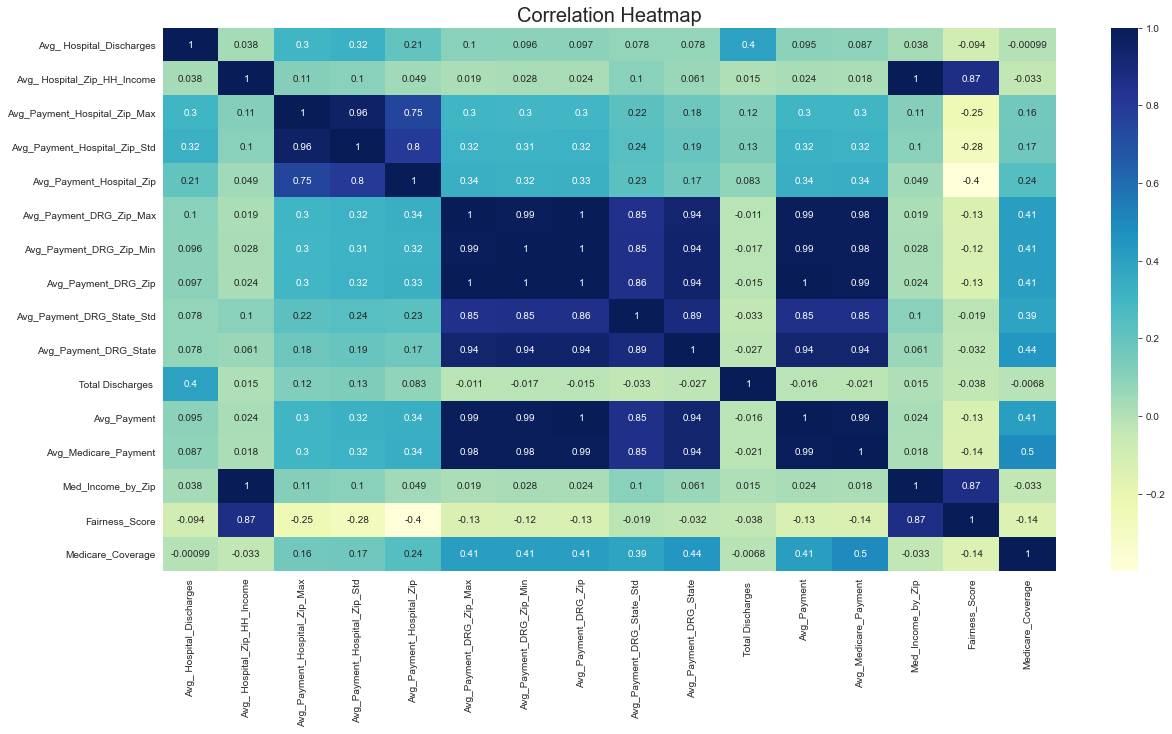

In [27]:
# Heatmap reveals there is multicollinearity in the dataset and this needs to be eliminated
corr = df_cluster.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr,annot=True,cmap='YlGnBu', square=False)
plt.title('Correlation Heatmap',size=20)

#### Elimination of Multicollinear features based on Variance inflation factor score. My threshold point will be 10

In [28]:
def calculate_vif_(X, thresh=10):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables].head(3)
    df_final = X.iloc[:, variables]

calculate_vif_(df_cluster, thresh=10)

C:\Users\Public\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning:

divide by zero encountered in double_scalars



dropping 'Avg_ Hospital_Zip_HH_Income' at index: 1
dropping 'Avg_Payment_DRG_Zip' at index: 6
dropping 'Avg_Payment' at index: 9
dropping 'Avg_Payment_DRG_Zip_Min' at index: 5
dropping 'Avg_Payment_Hospital_Zip_Std' at index: 2
dropping 'Avg_Payment_DRG_Zip_Max' at index: 3
dropping 'Med_Income_by_Zip' at index: 7
dropping 'Avg_Payment_Hospital_Zip' at index: 2
dropping 'Avg_Payment_DRG_State' at index: 3
dropping 'Medicare_Coverage' at index: 6
Remaining variables:
Index(['Avg_ Hospital_Discharges', 'Avg_Payment_Hospital_Zip_Max',
       'Avg_Payment_DRG_State_Std', ' Total Discharges ',
       'Avg_Medicare_Payment', 'Fairness_Score'],
      dtype='object')


,Avg_ Hospital_Discharges,Avg_Payment_Hospital_Zip_Max,Avg_Payment_DRG_State_Std,Total Discharges,Avg_Medicare_Payment,Fairness_Score
0,25.038462,40029.12,1363.849184,23,6413.78,5.218083
1,34.381579,61300.63,1363.849184,11,8081.54,0.313740
2,34.381579,61300.63,5423.494870,34,16696.61,0.313740


In [29]:
selected = ['Avg_ Hospital_Discharges', 'Avg_Payment_Hospital_Zip_Max','Avg_Payment_DRG_State_Std', ' Total Discharges ',     
       'Avg_Medicare_Payment', 'Fairness_Score']
df_cluster = df_cluster[selected]

Text(0.5, 1.0, 'Correlation Heatmap after elimination')

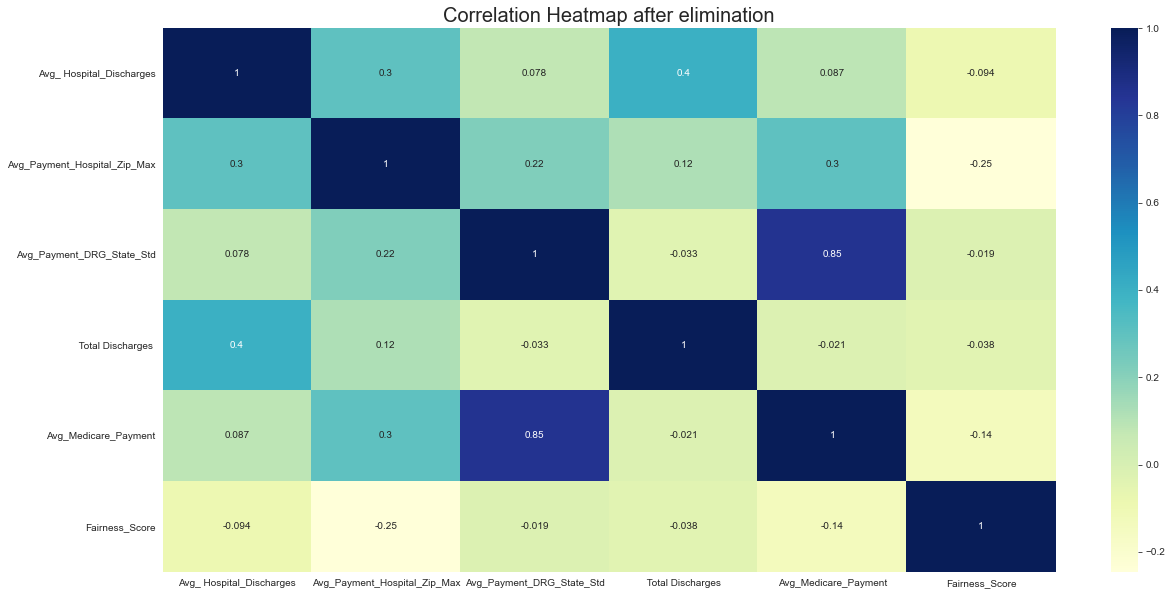

In [30]:
# Heatmap after multicollinearity
corr = df_cluster.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr,annot=True,cmap='YlGnBu', square=False)
plt.title('Correlation Heatmap after elimination',size=20)

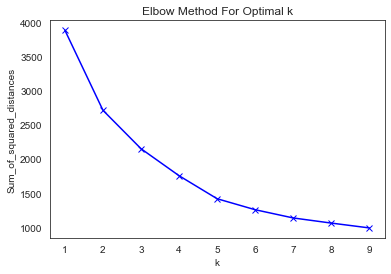

In [31]:
#Standardize Dataset
mms_t = MinMaxScaler()
mms_t.fit(df_cluster)
data_transformed_t = mms_t.transform(df_cluster)

#Generate Elbow Plot ranging between 2 to 9 clusters
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed_t)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Based on the elbow method 2 and 5 clusters scenario seems to be the optimal

#### To visualize clustering results on 2 Dimensions, I utilized PCA and reduced features into 2 dimensions

Text(0.5, 1.0, 'KMeans with 2 Clusters')

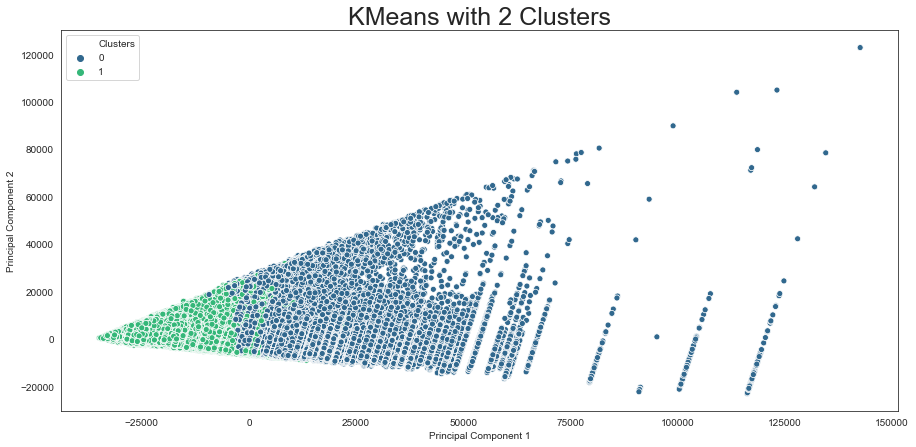

In [32]:
# Visualizing kmeans for 2 clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_transformed_t)
clusters = pd.DataFrame(kmeans.labels_).rename(columns=({0:'Clusters'}))

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_cluster)
df_2_dimensions = pd.DataFrame(data = principalComponents, columns = ['Principal Component 1', 'Principal Component 2'])

plot_dataframe = pd.concat([clusters, df_2_dimensions],axis=1)

plt.figure(figsize=(15,7))
sns.scatterplot(x='Principal Component 1',y='Principal Component 2',hue='Clusters',data=plot_dataframe,palette='viridis')
plt.title('KMeans with 2 Clusters',fontsize=25)

#### To capture more clusters in hopes of detecting abnormalities, I created a KMeans loop with a range from 10 to 18

In [33]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [34]:
# Above written code is to prevent graphs go into scroll down mode

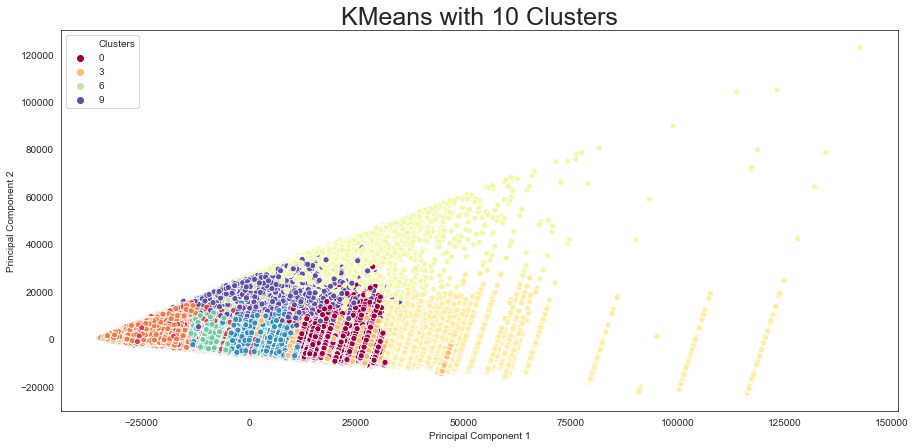

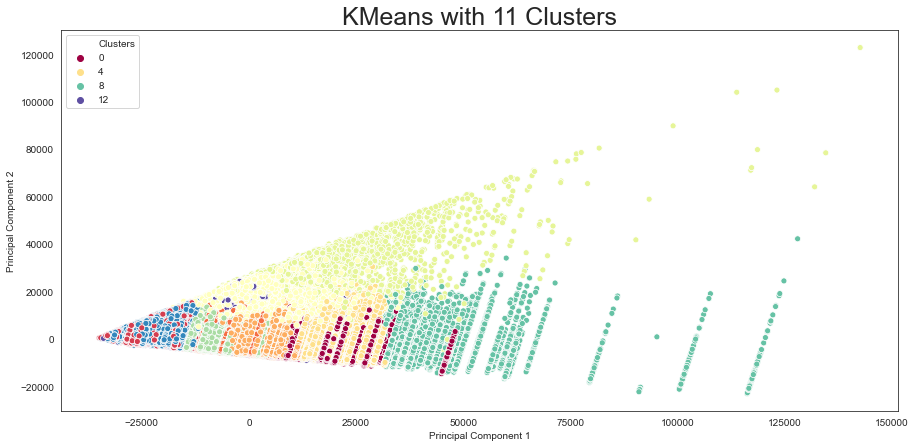

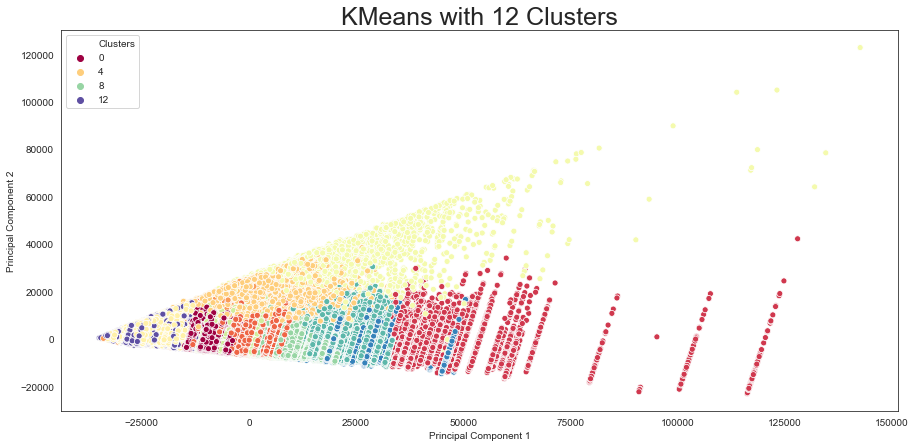

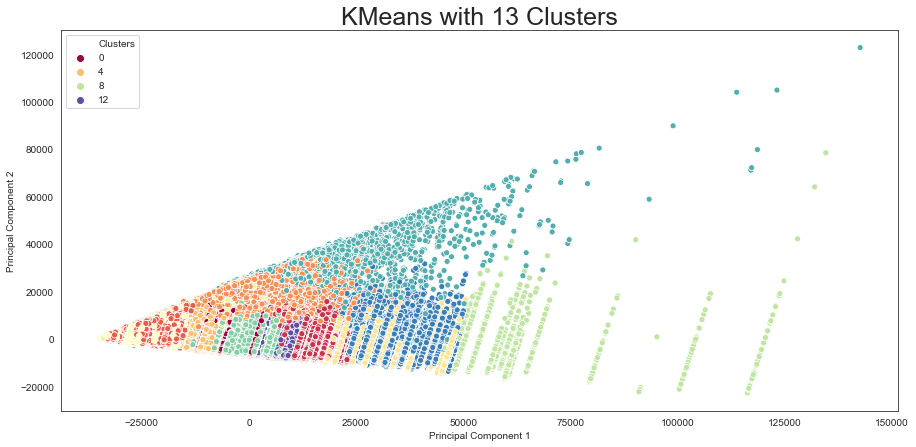

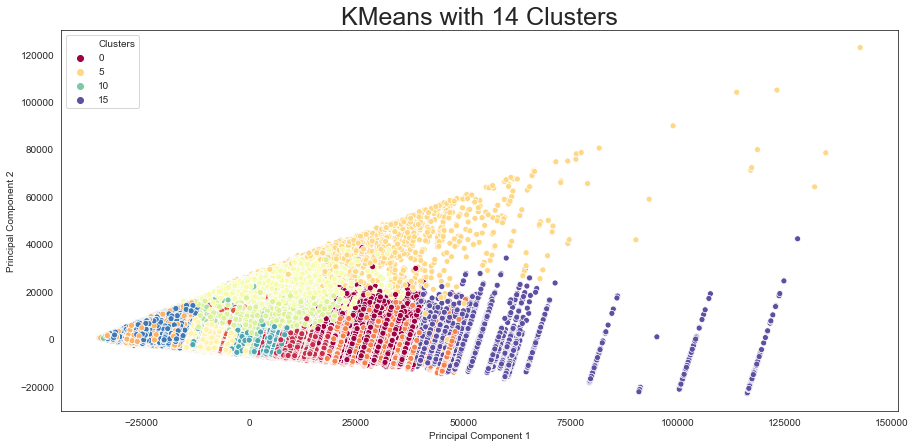

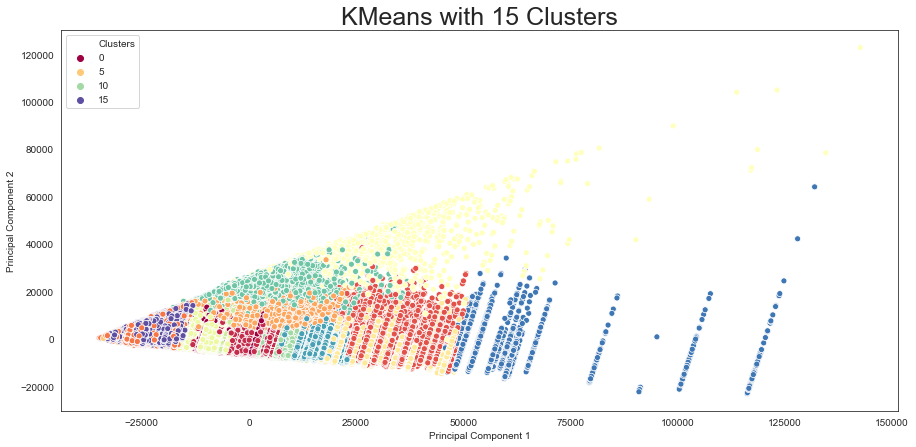

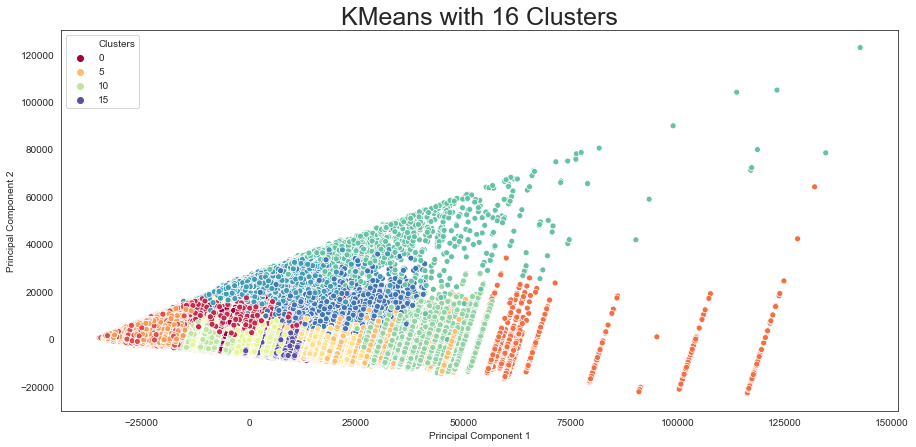

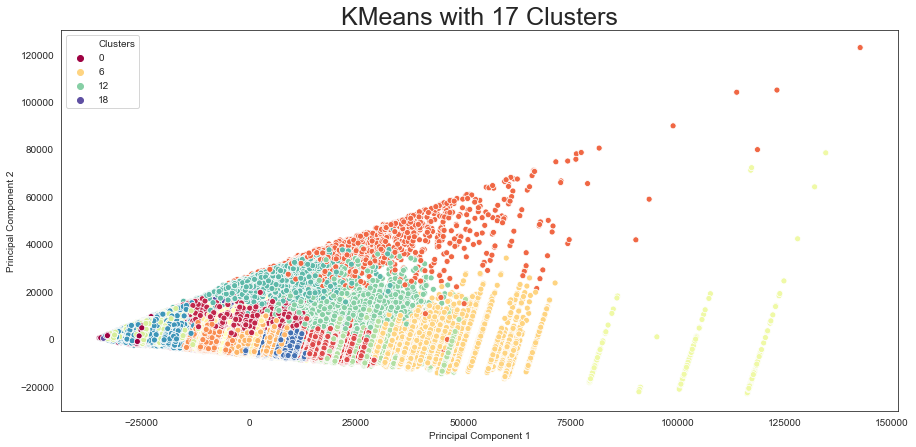

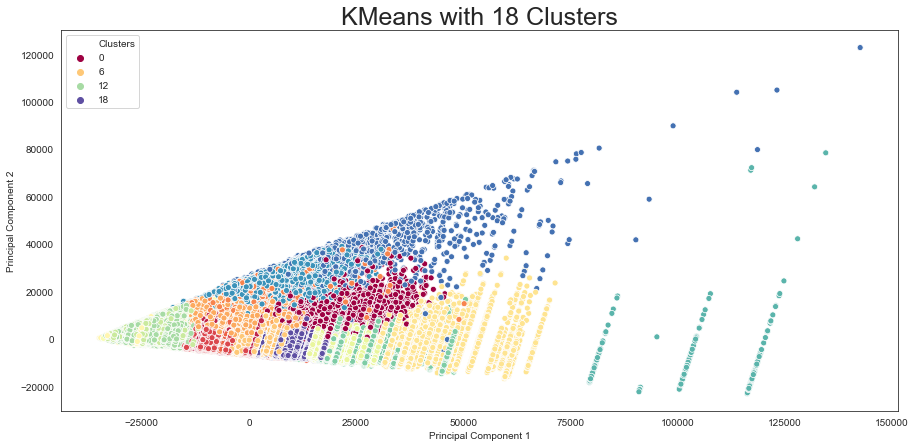

In [35]:
kmeans_trials = [10,11,12,13,14,15,16,17,18]
for i in kmeans_trials:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data_transformed_t)
    clusters = pd.DataFrame(kmeans.labels_).rename(columns=({0:'Clusters'}))
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df_cluster)
    df_2_dimensions = pd.DataFrame(data = principalComponents, columns = ['Principal Component 1', 'Principal Component 2'])
    plot_dataframe = pd.concat([clusters, df_2_dimensions],axis=1)
    plt.figure(figsize=(15,7))
    #sns.color_palette('Paired')
    sns.scatterplot(x='Principal Component 1',y='Principal Component 2',hue='Clusters',data=plot_dataframe,palette='Spectral') 
    plt.title('KMeans with ' + str(i) + ' Clusters',fontsize=25)

#### Based on the Kmeans loop, I noticed at the very right, there is an outlying data group. Then, I waited for the loop to perfectly seperate this departed chunk. At 16 cluster scenario, it seems to be properly seperated. Therefore, I move forward by utilizing Kmeans with 16 Clusters.

In [36]:
# 16 Clusters
kmeans = KMeans(n_clusters=16)
kmeans.fit(data_transformed_t)
clusters = pd.DataFrame(kmeans.labels_).rename(columns=({0:'Clusters'}))

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_cluster)
df_2_dimensions = pd.DataFrame(data = principalComponents, columns = ['PC_1', 'PC_2'])

df16 = pd.concat([clusters, df_2_dimensions],axis=1)
df16.head(3)

,Clusters,PC_1,PC_2
0,15,1879.824465,-2522.708895
1,1,23104.489031,-4692.735679
2,8,24741.022097,4448.620360


#### To determine which cluster is the outlier, I took the average of each principal components and visualize them on a scatterplot. The result indicates that especially clusters 12,9,8 and 3 extremely diverge from the remaining clusters.

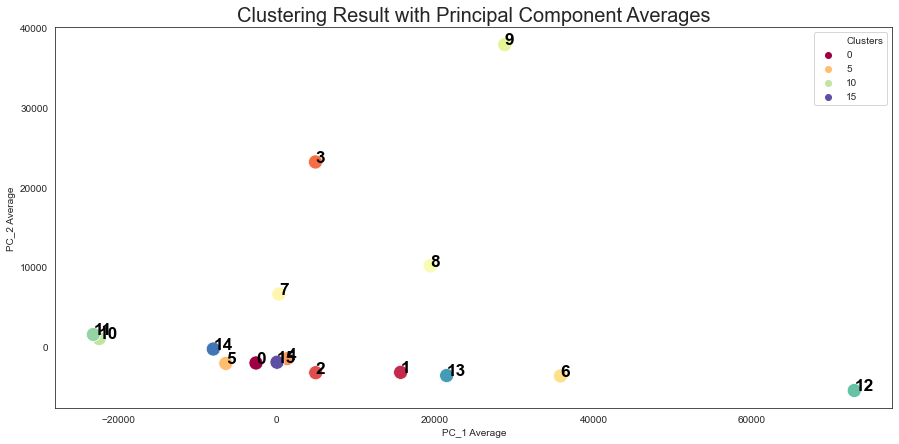

In [37]:
graph_16 = df16.groupby('Clusters').mean().reset_index().rename(columns = {'PC_1':'PC_1 Average','PC_2':'PC_2 Average'})
cluster_counts = df16.groupby('Clusters').count().reset_index().rename(columns = {'PC_1':'Count','PC_2':'Count2'})
graph_16 =pd.concat([graph_16,cluster_counts['Count']],axis=1)

plt.figure(figsize=(15,7))
pl = sns.scatterplot(x='PC_1 Average',y='PC_2 Average',hue='Clusters',data=graph_16,palette='Spectral',s=200 )
plt.title('Clustering Result with Principal Component Averages',fontsize=20)

# add annotations one by one with a loop
for line in range(0,graph_16.shape[0]):
     pl.text(graph_16['PC_1 Average'][line], graph_16['PC_2 Average'][line], graph_16.Clusters[line], horizontalalignment='left', size='xx-large', color='black', weight='semibold')        

#### Looking into standart deviation values, clusters 12, 9 and 8 are still the ones with highest divergence. 

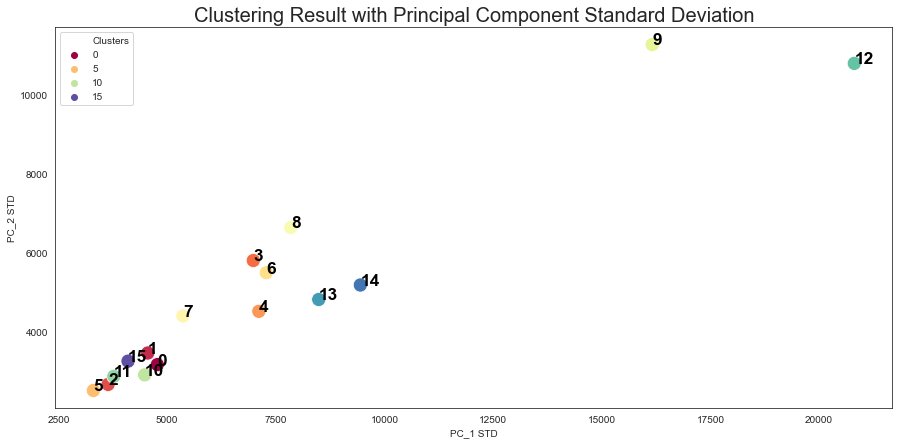

In [38]:
graph_16 = df16.groupby('Clusters').std().reset_index().rename(columns = {'PC_1':'PC_1 STD','PC_2':'PC_2 STD'})
cluster_counts = df16.groupby('Clusters').count().reset_index().rename(columns = {'PC_1':'Count','PC_2':'Count2'})
graph_16 =pd.concat([graph_16,cluster_counts['Count']],axis=1)

plt.figure(figsize=(15,7))
pl = sns.scatterplot(x='PC_1 STD',y='PC_2 STD',hue='Clusters',data=graph_16,palette='Spectral',s=200 )
plt.title('Clustering Result with Principal Component Standard Deviation',fontsize=20)

# add annotations one by one with a loop
for line in range(0,graph_16.shape[0]):
     pl.text(graph_16['PC_1 STD'][line], graph_16['PC_2 STD'][line], graph_16.Clusters[line], horizontalalignment='left', size='xx-large', color='black', weight='semibold')    

#### As I defined 12,9 and 8 my usual suspects, let's look into their share in the dataset. I would expect these clusters to have very small shares compared to other clusters.

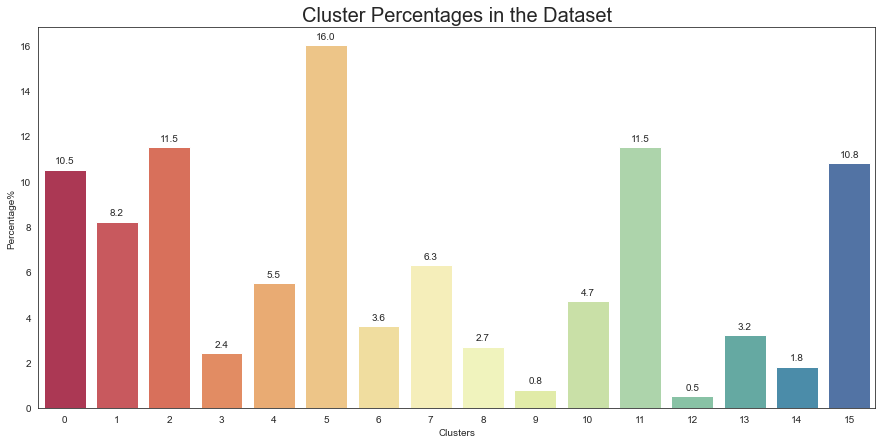

In [39]:
graph_16['Percentage%'] = ( (graph_16.Count/ sum(graph_16.Count) )*100).round(1)

plt.figure(figsize=(15,7))   
plt.title("Cluster Percentages in the Dataset",fontsize=20)
splot = sns.barplot(x='Clusters',y='Percentage%',data=graph_16,palette='Spectral')
          
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

#### As it can be clearly seen, both 12, 9 and 8 represent around 4% of the entire dataset which is very appropriate, since abnormal situations rarely occur 

#### Consequently, data points which fall under cluster 12, 9 and 8 need to be carefully examined since they pose a risk of being fraud